In [1]:
import lasagne
import numpy as np
import matplotlib.pyplot as plt
from theano import tensor as tnsr
from theano import function, shared
from hrf_fitting.src.feature_weighted_rf_models import receptive_fields
from hrf_fitting.src.features import make_space

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Dimensions

In [3]:
T = 256 ##trials
D = 64 ##features
S = 125 ##pixels
V = 100 ##voxels
deg_per_stim = 20




In [264]:
class receptive_field_layer(lasagne.layers.Layer):
    '''
    receptive_field_layer(incoming, num_rfs, (X_grid, Y_grid), deg_per_stim, x0=None, y0=None, sig=None)
    
    --inputs
    incoming ~ should be an input layer with (T,D,S,S) input_var tensor4
    
    num_rfs  ~ G, which in this case will almost certainly be V = the number of voxels you are trying to model
    
    (X_grid, Y_grid) ~ numpy matrices of spatial 2D grid specified in pixels. output "make_space" or np.meshgrid
    
    when x0,y0,sig=None initializes each rf with (x0,y0)=(0,0), stdev = 1. otherwise, can initialize with a theano shared variable or numpy array
    
    --attributes
    params are [x0, y0, sig], which are the (x,y) coors and standard dev., resp., of the gaussian rfs
    for some set of voxels
    
    make_rf_stack() will construct a stack of visualizable rf's
    '''    
    def __init__(self, incoming, num_rfs, space_grid, deg_per_stim, x0=None, y0=None, sig=None, dtype='float32', **kwargs):
        super(receptive_field_layer, self).__init__(incoming, **kwargs)  ##this will give us an "input_shape" attribute
        self.S = self.input_shape[-1]
        self.G = num_rfs
        
        self.pix_per_deg = self.S * (1./deg_per_stim)  ##this will convert into pixels
        self.Xm = shared(space_grid[0].astype(dtype))  ##explicit casting. is there a better way to do this?
        self.Ym = shared(space_grid[1].astype(dtype))
        if x0: ##we assume the shared variable has already been created and registered
            self.x0 = x0  
        else: ##we assume it has not
            self.x0 = self.add_param(np.zeros(num_rfs,dtype=dtype),(num_rfs,), name='x0',rf_param=True,x0=True)
        if y0:
            self.y0 = y0
        else:
            self.y0 = self.add_param(np.zeros(num_rfs,dtype=dtype),(num_rfs,), name='y0',rf_param=True,y0=True)
        if sig:
            self.sig = sig
        else:
            self.sig = self.add_param(np.ones(num_rfs,dtype=dtype),(num_rfs,), name='sig',rf_param=True,sig=True) 
        
        
        
        ##we put the pix_per_deg conversion here becuase x0,y0,sig will be shared across feature spaces
        self.gauss_expr = ((1. / 2*np.pi*(self.sig[:,np.newaxis,np.newaxis]*self.pix_per_deg)**2)
                           *tnsr.exp(-((self.Xm[np.newaxis,:,:]-self.x0[:,np.newaxis,np.newaxis]*self.pix_per_deg)**2
                                       + (self.Ym[np.newaxis,:,:]-self.y0[:, np.newaxis,np.newaxis]*self.pix_per_deg)**2)
                                     /(2*(self.sig[:,np.newaxis,np.newaxis]*self.pix_per_deg)**2)))
        
        self.make_rf_stack = function([],self.gauss_expr)
        
    
    def get_output_for(self, input, **kwargs):
        return tnsr.tensordot(self.gauss_expr, input, axes=[[1,2],[2,3]])
    
    def get_output_shape_for(self, input_shape): ##(G, T, D)
        return (self.G, input_shape[0], input_shape[1])
    
        

In [5]:
class compressive_nonlinearity_layer(lasagne.layers.Layer):
    def get_output_for(self, input, **kwargs):
        return tnsr.log(1+tnsr.sqrt(input))
    

In [218]:
class feature_weights_layer(lasagne.layers.Layer):
    '''
    feature_weights_layer(incoming, num_outputs, NU = lasagne.init.Constant([0]))
       incoming ~ should be an model space tensor (num_rfs,T,D)
    num_outputs ~ should be thought of as "number of voxels per receptive field".
                  if running grid search over possible rf models, each of the G rf models is potential model for each
                  voxel, so set num_outputs = num_voxels (i.e., "V").
                  if running gradient descent on params of one rf model per voxel, num_outputs = 1
             NU ~ (num_rfs,D,num_outputs) tensor of feature weights.
    output      ~ (num_rfs, T, num_outputs) tensor3 of predicted responses.
    '''    
    def __init__(self, incoming, num_outputs, NU = lasagne.init.Constant([0]), **kwargs):
        ##this will give us an "input_shape" attribute
        super(feature_weights_layer, self).__init__(incoming, **kwargs)  
        self.G = self.input_shape[0]
        self.D = self.input_shape[2]
        self.num_outputs = num_outputs
        ##creates the theano shared variable
        self.NU = self.add_param(NU, (self.G,self.D,num_outputs), name='feature_weights', feature_weights=True) 
    
    def get_output_for(self, input, **kwargs):
        return tnsr.batched_tensordot(input,
                                      self.NU,
                                      axes=[[2],[1]]) ##prediction tensor: num_rfs x T x num_outputs
    
    def get_output_shape_for(self, input_shape): ##input_shape = (num_rfs, T, D)
        return (self.G, input_shape[1], self.num_outputs)

In [1073]:
class normalization_layer(lasagne.layers.Layer):
    def __init__(self, incoming, mean=lasagne.init.Constant([0]), stdev=lasagne.init.Constant([1])):
        super(normalization_layer,self).__init__(incoming, **kwargs)
        self.G = self.input_shape[0]
        self.D = self.input_shape[2]
        self.mean = self.add_param(mean, (self.G, self.D), name='mean', trainable=False)
        self.stdev = self.add_param(stdev, (self.G, self.D), name='stdev', trainable=False)
    
    def get_output_for(self, input, **kwargs):
        return (input - self.mean[:,np.newaxis,:])/self.stdev[:,np.newaxis,:]


In [319]:
#### construct a fwrf model space: THIS SHOULD BE A BASE CLASS METHOD!!!
def make_fwrf_model_space(feature_map_dict, num_rfs, deg_per_stim):
    '''
    each dict value is a (T,D_i,S_i,S_i) stack of feature maps, where i indexes each stack of feature maps
    each model space in the list will have output shape (G,T,D)
    will concatenate along axis 2 (= D)
    will share x0,y0,sig (the rf params) across feature spaces
    '''
    model_space_list = []
    input_var_dict = {}
    for f_map_name in feature_map_dict.keys():
        input_shape = (None,)+feature_map_dict[f_map_name].shape[1:]
        
        ##one way to do this
        input_var_dict[f_map_name] = tnsr.tensor4(f_map_name)
        
        
        
        l1 = lasagne.layers.InputLayer(input_shape, input_var = input_var_dict[f_map_name], name='input_'+f_map_name)
        Xm,Ym = make_space(input_shape[-1])
        if not model_space_list:  
            l2 = receptive_field_layer(l1,num_rfs,(Xm,Ym),deg_per_stim,name='rf_'+f_map_name)
            model_space_list.append(l2)
        else: ##rf centers/sizes will be shared
            model_space_list.append(receptive_field_layer(l1,num_rfs,(Xm,Ym),deg_per_stim,
                                                          x0=l2.x0,
                                                          y0=l2.y0,
                                                          sig=l2.sig,
                                                          name='rf_'+f_map_name))
    
    fwrf_model_space = lasagne.layers.ConcatLayer(model_space_list,axis=2, name='fwrf_model_space')

    return input_var_dict, l2, fwrf_model_space
        
        

In [ ]:
##merges multiple feature map stacks, applies receptive field layer, and whatever else you want.
class fwrf(object):
    '''
    
    TODO: a decoding method for the base class? 
        
    fwrf( feature_map_dict, deg_per_stim, num_rfs, [rf_init={x0:array, y0:array, sig:array}])
    
    this is an abstract base class: to be inherited, not instantiated.
    
    merges multiple feature map stacks, applies receptive field layer, creates a dictionary of input tensors
    corresponding to each feature map stack, and creates an "rf_layer" attribute for convenient access to rf
    parameters.
    
    does not apply the feature_weights layer. too many different branches after rf application for that to be useful.
    
    once "fwrf" is defined, there are some useful methods for setting/getting param values
    
    once "loss" is defined, there is a useful method for building a kernel for learning.
    '''
    
    ##not overwrite
    def __init__(self, feature_map_dict, deg_per_stim, num_rfs, rf_init=None):
        ##voxel data tensor
        self.voxel_data_tnsr = tnsr.matrix('voxel_data_tnsr')  ##voxel data tensor: (T x V)
        
        
        ##record and store basic properties of the feature maps
        self.feature_depth = {}
        self.feature_indices = {}
        self.feature_resolutions = {}
        idx = 0
        for f_key in feature_map_dict.keys():
            self.feature_depth[f_key] = feature_map_dict[f_key].shape[1]
            self.feature_indices[f_key] = np.arange(idx,idx + self.feature_depth[f_key],step=1)
            idx += self.feature_depth[f_key]
            self.feature_resolutions[f_key] = feature_map_dict[f_key].shape[2]
        
        ##total feature depth
        self.D = np.sum(self.feature_depth.values())
        
        ##rf properties
        self.voxels_per_rf = voxels_per_rf ## this is really number of voxels per rf
        self.deg_per_stim = deg_per_stim
        self.num_rfs = num_rfs
        if not rf_info:
            rf_info = {}
            rf_info['x0'] = np.zeros(num_rfs,dtype='float32')
            rf_info['y0'] = np.zeros(num_rfs,dtype='float32')
            rf_info['sig'] = np.ones(num_rfs,dtype='float32')
        else:
            
    
        ##construct model space network: applies rf's to feature maps
        self.input_var_dict, self.rf_layer, self.model_space = make_fwrf_model_space(feature_map_dict, self.num_rfs, deg_per_stim)

        self.rf_layer.x0.set_value(rf_info['x0'])
        self.rf_layer.y0.set_value(rf_info['y0'])
        self.rf_layer.sig.set_value(rf_info['sig'])
        
        

    def set_model_params(self,**kwargs):
        for shared_var in lasagne.layers.get_all_params(self.fwrf):
            if shared_var.name in kwargs.keys():
                shared_var.set_value(kwargs[shared_var.name])
    
    def get_param_shapes(self, *args):
        param_shape_dict = {}
        for shared_var in lasagne.layers.get_all_params(self.fwrf):
            if shared_var.name in args:
                param_shape_dict[shared_var.name] = shared_var.get_value().shape
                print 'parameter %s has shape %s' %(shared_var.name, param_shape_dict[shared_var.name])
        return param_shape_dict
    
    def get_param_values(self, *args):
        param_value_dict = {}
        for shared_var in lasagne.layers.get_all_params(self.fwrf):
            if shared_var.name in args:
                param_value_dict[shared_var.name] = shared_var.get_value()
        return param_value_dict
            
        
    def _build_training_kernel(self, learning_rate):
        params = lasagne.layers.get_all_params(self.fwrf,trainable=True)
        print 'will solve for: %s' %(params)
        fwrf_update = lasagne.updates.adagrad(self.loss_expr,params,learning_rate=learning_rate)
        ##training kernel
        self.trn_kernel = function([self.voxel_data_tnsr]+self.input_var_dict.values(), self.loss_expr, updates=fwrf_update)
    
    def _descend_and_validate(self, trn_in, trn_out, val_in, val_out, check_every=10):
        step_count = 0
        while step_count < check_every:
            _ = self.trn_kernel(trn_out, *trn_in.values()) 
            step_count += 1
        trn_loss_is = self.loss(trn_out, *trn_in.values())     
        val_loss_is = self.loss(val_out, *val_in.values()) 
        return val_loss_is, trn_loss_is
    
    def _build_loss(self):
        raise NotImplementedError('must return self.loss_expr')
    
    def _build_pred(self):
        raise NotImplementedError('must return self.pred_expr')
        
    def _construct_network(self):
        raise NotImplementedError('must return self.fwrf')
    
    def decode(self, decode_params)    

In [1072]:
class coarse_fwrf(fwrf):
    def __init__(self, feature_map_dict, deg_per_stim, num_rfs, number_of_voxels, rf_init=None, activation_layer=None):
        super(coarse_fwrf, self).__init__(feature_map_dict, deg_per_stim, num_rfs, rf_init)
        self.number_of_voxels = number_of_voxels
        self.construct_network(activation_layer)
        self.build_expressions()
    
    def construct_network(self,activation_layer):
        if activation_layer:
            self.fwrf = activation_layer(self.model_space)
        else:
            self.fwrf = self.model_space
        
        self.fwrf = normalization_layer(self.fwrf)
        self.fwrf = feature_weights_layer(self.fwrf, self.number_of_voxels)
        
    def _build_mst(self, data_generator, num_samples, chunk_size):
        mst = np.zeros((self.num_rfs, num_samples, self.D), dtype='float32')
        cnt = 0
        for trn_in in data_generator:
            mst[:,cnt:cnt+chunk_size,:] = self._construct_model_space(trn_in)
            cnt += chunk_size
        return mst
    
    def normalize(self, *args):
        mst = self._build_mst(*args)
        mn = np.mean(mst, axis=1)
        stdev = 1+np.stdev(mst, axis=1)
        self.set_params()
    
    
            
    


True

In [539]:
feature_map_names = ['a','b','c']
feature_map_dict = {}
feature_depths = [12, 45, 78]
for fmap,fdep in zip(feature_map_names,feature_depths):
    feature_map_dict[fmap] = np.random.random(size=(T,fdep,S,S)).astype('float32')

num_voxels = 10

In [1043]:
foo = encoding_model(feature_map_dict, num_voxels, 20)

In [1046]:
network = lambda x: feature_weights_layer(lasagne.layers.BatchNormLayer(x,axes=(1,)), foo.num_outputs)
#lasagne.layers.BatchNormLayer(compressive_nonlinearity_layer(

In [1047]:
foo.construct_network(network)

In [1048]:
NU=np.random.random(size=(foo.num_voxels, foo.D, foo.num_outputs)).astype('float32')
foo.set_model_params(feature_weights=NU)

In [1049]:
x0 = 4*np.random.random(size=(num_voxels)).astype('float32')
y0 = 4*np.random.random(size=(num_voxels)).astype('float32')
sig = 4*np.random.random(size=(num_voxels)).astype('float32')
foo.set_model_params(rf_center = (x0,y0), rf_size = sig)

In [886]:
# param_shapes = foo.get_param_shapes('beta', 'gamma')
# b = np.zeros(param_shapes['beta'], dtype='float32')
# g = np.ones(param_shapes['gamma'], dtype='float32')
# foo.set_model_params(beta=b, gamma=g)

KeyError: 'beta'

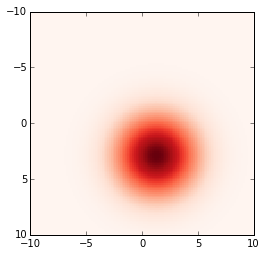

In [1050]:
extent=[-deg_per_stim/2.,deg_per_stim/2.,deg_per_stim/2.,-deg_per_stim/2.]
plt.imshow(foo.rf_layer.make_rf_stack()[-1,:,:],cmap=plt.cm.Reds, interpolation='none', extent=extent)

In [1051]:
trn_in = {key: value[:-11,:,:,:] for key,value in feature_map_dict.iteritems()}
val_in = {key: value[-11:,:,:,:] for key,value in feature_map_dict.iteritems()}
trn_out = foo.predicted_activity(*trn_in.values())
val_out = foo.predicted_activity(*val_in.values())

In [1052]:
print foo.loss(np.squeeze(val_out).T, *val_in.values())

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [1053]:
NU_start=np.zeros(shape=(foo.num_voxels, foo.D, foo.num_outputs)).astype('float32')
foo.set_model_params(feature_weights=NU_start)
# x0_start = 1*np.zeros(shape=(num_voxels)).astype('float32')
# y0_start = 1*np.zeros(shape=(num_voxels)).astype('float32')
# sig_start = 1*np.ones(shape=(num_voxels)).astype('float32')
# foo.set_model_params(rf_center = (x0_start,y0_start), rf_size = sig_start, feature_weights=NU_start)

# param_shapes = foo.get_param_shapes('beta', 'gamma')
# b = np.zeros(param_shapes['beta'], dtype='float32')
# g = np.ones(param_shapes['gamma'], dtype='float32')
# foo.set_model_params(beta=b, gamma=g)

start_val_err = foo.loss(np.squeeze(val_out).T, *val_in.values())
start_trn_err = foo.loss(np.squeeze(trn_out).T, *trn_in.values())
print start_trn_err

[[  2.39559237e+15]
 [  2.86052879e+17]
 [  6.16917399e+15]
 [  2.55340657e+18]
 [  4.52541849e+16]
 [  3.05872178e+17]
 [  6.67870045e+15]
 [  1.01723050e+07]
 [  3.14166292e+16]
 [  7.62574192e+16]]


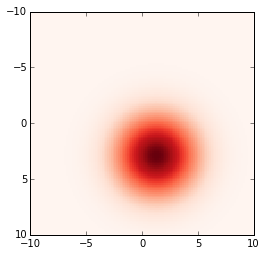

In [1054]:
extent=[-deg_per_stim/2.,deg_per_stim/2.,deg_per_stim/2.,-deg_per_stim/2.]
plt.imshow(foo.rf_layer.make_rf_stack()[-1,:,:],cmap=plt.cm.Reds, interpolation='none', extent=extent)

In [1055]:
# print lasagne.layers.get_all_param_values(foo.fwrf,trainable=True)
foo._build_training_kernel(1e-0)

will solve for: [rf_a.x0, rf_a.y0, rf_a.sig, beta, gamma, feature_weights]


In [1062]:
stop_val_err,stop_trn_err = foo._descend_and_validate(trn_in,np.squeeze(trn_out).T,val_in,np.squeeze(val_out).T,check_every=10)
print stop_trn_err/start_trn_err


[[ 300.61328125]
 [  34.80930328]
 [  22.4452858 ]
 [  14.22865105]
 [  26.59971428]
 [ 233.33322144]
 [ 186.52301025]
 [ 963.64562988]
 [ 364.03448486]
 [ 236.4291687 ]]


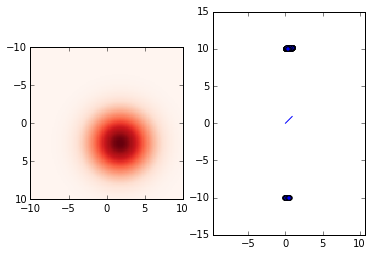

In [1065]:
extent=[-deg_per_stim/2.,deg_per_stim/2.,deg_per_stim/2.,-deg_per_stim/2.]
plt.subplot(1,2,1)
plt.imshow(foo.rf_layer.make_rf_stack()[-1,:,:],cmap=plt.cm.Reds, interpolation='none', extent=extent)
plt.subplot(1,2,2)
_=plt.scatter(NU[2,:, 0],foo.get_param_values('feature_weights')['feature_weights'][2,:, 0])
_=plt.plot(np.arange(0,1,.10),np.arange(0,1,.10),hold=True)
_=plt.axis('equal')

In [1064]:
NU.shape

(10, 135, 1)

[[  2.75007483e-06]
 [  5.44622999e-05]
 [  4.64585992e-06]
 [  1.47744061e-06]
 [  3.12452812e-06]
 [  2.45448831e-07]
 [  8.94460027e-06]
 [  3.25691371e-06]
 [  6.40929898e-07]
 [  3.96716587e-06]]


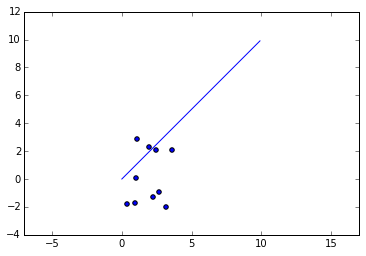

In [1027]:
_=plt.scatter(y0,foo.get_param_values('rf_a.y0')['rf_a.y0'])
_=plt.plot(np.arange(0,10,.10),np.arange(0,10,.10),hold=True)
_=plt.axis('equal')
print stop_val_err/start_val_err

In [823]:
0.11138599

0.11138599

In [ ]:
####===================ORPHANAGE=========================

In [921]:
        
#     def _build_trn_pred(self):
#         self.trn_pred_expr = lasagne.layers.get_output(self.fwrf)
#         #self.trn_pred_func = function(self.input_var_dict.values(), self.trn_pred_expr)
    
#     def _build_val_pred(self):
#         ##this will make predictions using the current normalization params (i.e., since the last call of trn_pred_func)
#         self.val_pred_expr = lasagne.layers.get_output(self.fwrf, deterministic='True')
#         ##FUNCTION
#         self.predicted_activity = function(self.input_var_dict.values(), self.val_pred_expr)
        
#     def _build_trn_loss(self):
#         ##training loss expression: same as above except for the last summing step. so:
#         trn_diff = self.voxel_data_tnsr.T[:,:,np.newaxis]-self.trn_pred_expr  ##difference tensor: (V x T x 1) - (V x T x 1) = (V x T x 1)
#         self.trn_loss_expr = (trn_diff*trn_diff).sum(axis=1).sum() ##sum-sqaured-diffs tensor: V x 1
    
#     def _build_val_loss(self): 
#         ##validation loss
#         val_diff = self.voxel_data_tnsr.T[:,:,np.newaxis]-self.val_pred_expr  ##difference tensor: (V x T x 1) - (V x T x 1) = (V x T x 1)
#         self.val_loss_expr = (val_diff*val_diff).sum(axis=1) ##sum-sqaured-diffs tensor: V x 1
#         ##FUNCTION
#         self.loss = function([self.voxel_data_tnsr]+self.input_var_dict.values(), self.val_loss_expr)

        
        
              

#### How to build an input layer

In [49]:
####input shape
input_shape = (T,D,S,S)
####this tensor stores feature map
f_map_0 = tnsr.tensor4('f_map_0',dtype='float32')  ##(T,D,S,S)

In [51]:
####the lasagne input layer
layer_1 = lasagne.layers.InputLayer(input_shape, input_var = f_map_0, name='layer_1')

#### Test the rf layer
Output will have model-space tensor dimensions. 

In [52]:
G = 48
deg_per_stim = 20

In [53]:

rf_layer = receptive_field_layer(layer_1, G, make_space(S), deg_per_stim)

##### see initial stack of rfs -- they are all the same

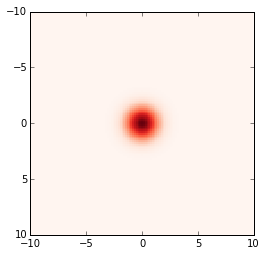

In [78]:
extent=[-deg_per_stim/2.,deg_per_stim/2.,deg_per_stim/2.,-deg_per_stim/2.]
plt.imshow(rf_layer.make_rf_stack()[-1,:,:],cmap=plt.cm.Reds, interpolation='none', extent=extent)

##### but now change them, and re-view them
NOTE: everytyhing is specified in degrees.


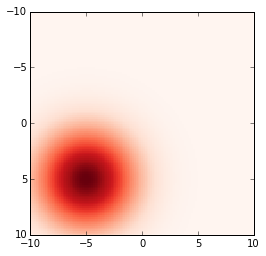

In [15]:
rf_layer.x0.set_value(-5*np.ones(G).astype('float32'))
rf_layer.y0.set_value(5*np.ones(G).astype('float32'))
rf_layer.sig.set_value(3*np.ones(G).astype('float32'))
plt.imshow(rf_layer.make_rf_stack()[3,:,:],cmap=plt.cm.Reds, interpolation='none', extent=extent)

##### compile output function, test shape

In [16]:
prediction = lasagne.layers.get_output(rf_layer)
pred_func = function([layer_1.input_var], prediction)

In [17]:
outp = pred_func(np.zeros(input_shape).astype('float32'))
print outp.dtype
print outp.shape

float32
(48, 256, 64)


##### check out the params

In [18]:
lasagne.layers.get_all_params(rf_layer)

[x0, y0, sig]

#### Test the activation layer
For the gabor model, we sometimes use the log(1+sqrt(x)) transforms. Here's that:

In [54]:
act_layer = compressive_nonlinearity_layer(rf_layer)

In [20]:
lasagne.layers.get_all_params(act_layer)

[x0, y0, sig]

In [21]:
l_3 = lasagne.layers.get_output(act_layer)
l_3_func = function([layer_1.input_var], l_3)

In [22]:
l_3_func(np.zeros(input_shape).astype('float32')).shape

(48, 256, 64)

#### Normalization layer
    pass deterministic=False for training
    pass deterministic=True for validation
    in our case output shape = (G,T,D), so normalization must integrate over axis=1
    this will give mean/stdev/gamma/beta params of shape (G,D)

In [79]:
norm_layer = lasagne.layers.BatchNormLayer(rf_layer, axes=(1,))

In [80]:
print norm_layer.mean.get_value().shape
print norm_layer.inv_std.get_value().shape
print norm_layer.gamma.get_value().shape
print norm_layer.beta.get_value().shape

(48, 64)
(48, 64)
(48, 64)
(48, 64)


##### so everytime you call the layer_4 output function the mean/stdev params are updated.
but if you call with deterministic='True', the mean/stdev are not updated, they are fixed.

In [82]:
norm_pred_expr = lasagne.layers.get_output(norm_layer)
norm_pred_func = function([layer_1.input_var], norm_pred_expr)

In [88]:
x = np.random.random(size=input_shape).astype('float32')
_=norm_pred_func(x)
before= norm_layer.mean.get_value()
for _ in range(10):
    x = np.random.random(size=input_shape).astype('float32')
    um=norm_pred_func(x)
after = norm_layer.mean.get_value()

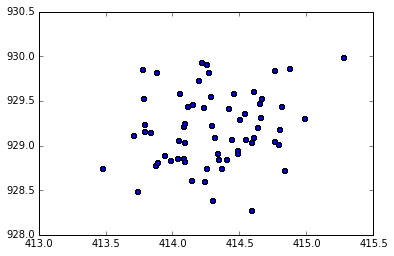

In [89]:
plt.scatter(before,after)
# lims = [np.min(after), np.max(after)]
# plt.xlim(lims)
# plt.ylim(lims)

...call layer_4 output function with deterministic='Trure' in a loop, and means are updated stay fixed

In [90]:
norm_pred_expr_fixed = lasagne.layers.get_output(norm_layer, deterministic = 'True')
norm_pred_func_fixed = function([layer_1.input_var], norm_pred_expr_fixed)

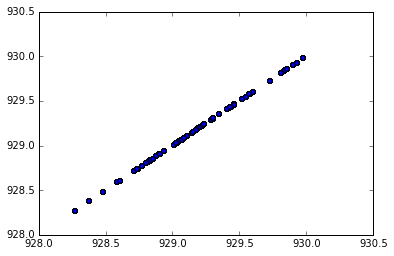

In [91]:
before= norm_layer.mean.get_value()
for _ in range(10):
    x = np.random.random(size=input_shape).astype('float32')
    _=norm_pred_func_fixed(x)
after = norm_layer.mean.get_value()
plt.scatter(before,after)

#### Feature weights layer


In [92]:
layer_5 = feature_weights_layer(norm_layer,1)

In [93]:
layer_5_pred_expr = lasagne.layers.get_output(layer_5)

In [94]:
layer_5_pred_func = function([layer_1.input_var],layer_5_pred_expr)

In [95]:

layer_5_pred_func(x).shape

(48, 256, 1)

#### Putting it all together
Usually we'll have multiple features spaces, where each feature space is a stack of feature maps with the same 
resolution.  
Because resolution can vary, we'll need construct separate rf layers for each feature space.  
Then, we can merge the feature spaces, and apply whatever normalization, nonlinearity, etc. we want before apply the feature weights.

##### construct feature space dictionary

In [166]:
feature_map_names = ['a','b','c']
feature_map_dict = {}
feature_depths = [12, 45, 78]
for fmap,fdep in zip(feature_map_names,feature_depths):
    feature_map_dict[fmap] = np.random.random(size=(T,fdep,S,S)).astype('float32')

num_rfs = 10

In [167]:
##construct model space
input_var_dict, model_space = make_fwrf_model_space(feature_map_dict, num_rfs, deg_per_stim)

test the model space part

In [168]:
print model_space.get_output_shape_for([input_shape])

model_space_pred_expr = lasagne.layers.get_output(model_space)
model_space_pred_func = function(input_var_dict.values(), model_space_pred_expr)

(256, 64, 125, 125)


In [172]:
lasagne.layers.get_all_params(model_space,rf_param=True)

[rf_a.x0, rf_a.y0, rf_a.sig]

In [173]:
print model_space_pred_func(*feature_map_dict.values()).shape
print sum(feature_depths)

(10, 256, 135)
135


check the parameters

### Two ways to train

**Method 1**: Grid search over many rfs for each voxel. In this case we run the model space+act+norm network to construct a model-space tensor for the training and testing data. Then we construct a simple linear network where we just apply the feature weights to the mst. We do this to avoid having to re-apply the rf models to the feature maps each time we want to make a prediction. The gradient of loss is now w.r.t. to the feature weights only, but the training procedure needs to include a mechanism for selecting the best rf for each voxel.

In [102]:
##define the model space network
model_space = compressive_nonlinearity_layer(model_space)
model_space = lasagne.layers.BatchNormLayer(model_space, axes=(1,))

In [103]:
##define the prediction expression / function
model_space_pred_expr = lasagne.layers.get_output(model_space, deterministic='False')
model_space_pred_func = function(input_var_dict.values(), model_space_pred_expr)

In [107]:
##construct the mst
mst = model_space_pred_func(*feature_map_dict.values())
print mst.shape

(10, 256, 135)


In [108]:
##now construct full model: the input is the model space tensor
mst_tnsr = tnsr.tensor3('mst')
fwrf = lasagne.layers.InputLayer((mst.shape[0],None,mst.shape[-1]), input_var=mst_tnsr,name='fwrf')
fwrf = feature_weights_layer(fwrf,V)

In [109]:
##construct prediction expr: (G,T,V)
fwrf_pred_expr = lasagne.layers.get_output(fwrf)

In [110]:
##loss expression: we already have all this stuff from before
voxel_data_tnsr = tnsr.matrix('voxel_data_tnsr')  ##voxel data tensor: T x V
diff = voxel_data_tnsr-fwrf_pred_expr  ##difference tensor: (T x V) - (G x T x V) = (G x T x V)
sq_diff = (diff*diff).sum(axis=1) ##sum-sqaured-diffs tensor: G x V


fwrf_loss_expr = sq_diff.sum()  ##<<this sum is critical. theano knows not to differentiate w.r.t params if deriv. is always 0

In [111]:
##update rule
learning_rate = 0.1
params = lasagne.layers.get_all_params(fwrf)
fwrf_update = lasagne.updates.sgd(fwrf_loss_expr, params, learning_rate)

In [112]:
##training kernel: returns loss, updates params
trn_kernel = function([mst_tnsr,voxel_data_tnsr], fwrf_loss_expr, updates=fwrf_update)

In [113]:
##validation kernel: returns predictions and loss, leaves params alone
val_kernel = function([mst_tnsr, voxel_data_tnsr], [fwrf_pred_expr, fwrf_loss_expr])

In [117]:
neural_data = np.random.random(size=(T,V)).astype('float32')
print trn_kernel(mst, neural_data)

5.03935089508e+14


In [118]:
pred,loss = val_kernel(mst, neural_data)
print pred.shape
print loss

(10, 256, 100)
3.93386847789e+24


In [ ]:
##training proc: pseudo-code
# val_in, val_out = get_val_data(mst)
# for trn_in, trn_out in batch_generator(mst):
#     trn_loss = trn_kernel(trn_in, trn_out)
#     _,val_loss = val_kernel(val_in,val_out) ##don't really care about val_pred here
#     if val_loss is less_than_it_was:
#         rf_idx = select_best_rf(fwrf)
#         NU = select_best_weights(fwrf)
#     if val_loss is too_big:
#         break
# new_fwrf = make_best_model(rf_idx, NU)

**Method 2**: Gradient descent on rf parameters. In this case we optimize one rf per voxel using gradient descent. We build the full network and take gradients w.r.t. both the mean/size of each voxel's rf and the feature weights. 

In [174]:
##Construct the full model network
##add activation
fwrf = compressive_nonlinearity_layer(model_space)

##add normalization
fwrf = lasagne.layers.BatchNormLayer(fwrf, axes=(1,))

##add feature layer
num_outputs=1
fwrf = feature_weights_layer(fwrf,num_outputs)

In [175]:
##prediction expression with update of normalization params: ##V x T x 1
trn_pred_expr = lasagne.layers.get_output(fwrf)
# trn_pred_func = function(input_var_dict.values(), trn_pred_expr)

##this will make predictions using the current normalization params (i.e., since the last call of trn_pred_func)
val_pred_expr = lasagne.layers.get_output(fwrf, deterministic='True')
# val_pred_func = function(input_var_dict.values(), val_pred_expr)

In [176]:
##voxel data needed for loss
voxel_data_tnsr = tnsr.matrix('voxel_data_tnsr')  ##voxel data tensor: (T x V)

##training loss expression: same as above except for the last summing step. so:
trn_diff = voxel_data_tnsr.T[:,:,np.newaxis]-trn_pred_expr  ##difference tensor: (V x T x 1) - (V x T x 1) = (V x T x 1)
trn_loss = (trn_diff*trn_diff).sum(axis=1) ##sum-sqaured-diffs tensor: V x 1

##validation loss
val_diff = voxel_data_tnsr.T[:,:,np.newaxis]-val_pred_expr  ##difference tensor: (V x T x 1) - (V x T x 1) = (V x T x 1)
val_loss = (val_diff*val_diff).sum(axis=1) ##sum-sqaured-diffs tensor: V x 1

In [187]:
lasagne.layers.get_all_params(fwrf,trainable=True)

[rf_a.x0, rf_a.y0, rf_a.sig, beta, gamma, feature_weights]

In [178]:
##-----check the gradients
fw_grad = tnsr.grad(trn_loss.sum(),fwrf.NU)
rf_grad = tnsr.grad(trn_loss.sum(),lasagne.layers.get_all_params(fwrf,rf_param=True))


##functionalize
fw_grad_func = function([voxel_data_tnsr]+input_var_dict.values(), fw_grad)
rf_grad_func = function([voxel_data_tnsr]+input_var_dict.values(), rf_grad)

In [190]:
encoding_grad = tnsr.grad(trn_loss.sum(),lasagne.layers.get_all_params(fwrf,trainable=True))
encoding_grad_func = function([voxel_data_tnsr]+input_var_dict.values(), encoding_grad)

In [198]:
print fw_grad_func(neural_data,*feature_map_dict.values()).shape

(10, 135, 1)


In [179]:
neural_data = np.random.random(size=(T,num_rfs)).astype('float32')

In [193]:
grads= encoding_grad_func(neural_data,*feature_map_dict.values())

In [197]:
grads[-1].shape

(10, 135, 1)

In [182]:
rf_grad_func(neural_data,*feature_map_dict.values())

[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)]

In [199]:
##update rule
learning_rate = 0.1
params = lasagne.layers.get_all_params(fwrf,trainable=True)
fwrf_update = lasagne.updates.sgd(trn_loss.sum(),params,learning_rate)

In [200]:
##training kernel
trn_kernel = function(input_var_dict.values()+[voxel_data_tnsr], trn_loss, updates=fwrf_update)

In [201]:
##validation kernel
val_kernel = function(input_var_dict.values()+[voxel_data_tnsr], [val_pred_expr,val_loss])

In [ ]:
##training proc: pseudo-code
# val_in, val_out = get_val_data(mst)
# for trn_in, trn_out in batch_generator(mst):
#     trn_loss = trn_kernel(trn_in, trn_out)
#     _,val_loss = val_kernel(val_in,val_out) ##don't really care about val_pred here
#     if val_loss is less_than_it_was:
#         NU = lasagne.layers.get_param_values(fwrf)[-1]  ##<<something like this
#     if val_loss is too_big:
#         break
# new_fwrf = make_best_model(NU)

### Decoding
uses "new_fwrf" resulting from one of the two training methods.
How to treat input layer?
Link input to a shared variable? Probably a bad idea.
Create a feature map layer that has a shared variable param? When building the "new_fwrf", make a decoding version with this feature map layer at the front?
Or: just dont' use shared variable here...probably the best idea.

In [206]:
decoding_pred_expr = lasagne.layers.get_output(fwrf, deterministic='True') ##V x T x 1
target_activity = tnsr.matrix('target_activity')  #T x V
decoding_loss = val_loss.sum()

In [208]:
##apparently, the input_var can't be share variable, so we'll have to do updates explicitly
decoding_grad = tnsr.grad(decoding_loss,wrt=input_var_dict.values())
decoding_grad_func = function([voxel_data_tnsr]+input_var_dict.values(), decoding_grad)

In [215]:
decodeable_pattern = np.random.random(size=(T,num_rfs)).astype('float32')

In [216]:
d_grad = decoding_grad_func(decodeable_pattern, *feature_map_dict.values())

In [217]:
len(d_grad)

3

In [220]:
foo = shared(np.ones((2,2)))

In [225]:
model_space.name

'fwrf_model_space'